<a href="https://colab.research.google.com/github/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/src/co2_forecasting_svr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing support-vector-regression(svr) forecasting model...
Start Program...
lag = 12
Cross validation = 0
Heatmap = 0
Loading .xlsx data...
fitting-model: SVR (kernel:rbf)  rmse Model 0= 0.007824076994913876
forecasting-model: SVR (kernel:rbf)  rmse Model 0= 0.6235170443893797
fitting-model: SVR (kernel:rbf)  rmse Model 1= 0.007860488838933845
forecasting-model: SVR (kernel:rbf)  rmse Model 1= 0.7287902878494531
fitting-model: SVR (kernel:linear)  rmse Model 2= 0.007848040908580614
forecasting-model: SVR (kernel:linear)  rmse Model 2= 0.8425651138841667
fitting-model: SVR (kernel:rbf)  rmse Model 3= 0.007843936386245668
forecasting-model: SVR (kernel:rbf)  rmse Model 3= 0.662623344981152


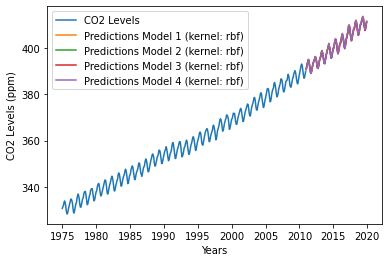

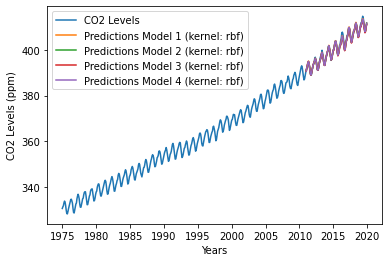

End of Program...


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.dates as md
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
import operator
import pprint
pp = pprint.PrettyPrinter(indent=4,width=40)
import seaborn as sns

# Whole Dataset
DATASET = "https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/co2_dataset_preprocess.xlsx?raw=true"

# Cross-Validation Dataset
CV_DATASET = \
["https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/cv/co2_monthly_process_up_1.xlsx?raw=true" ,
 "https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/cv/co2_monthly_process_up_2.xlsx?raw=true" ,
 "https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/cv/co2_monthly_process_up_3.xlsx?raw=true" ,
 "https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/cv/co2_monthly_process_up_4.xlsx?raw=true",
 "https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/cv/co2_monthly_process_up_5.xlsx?raw=true",
 "https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/cv/co2_monthly_process_up_6.xlsx?raw=true",
 "https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/cv/co2_monthly_process_up_7.xlsx?raw=true"
 ]

print("Importing support-vector-regression(svr) forecasting model...")

def loadExcelData(filepath):
    print("Loading .xlsx data...")
    excelData = pd.ExcelFile(filepath)
    data = excelData.parse()
    return data

def convert_datetime(data):
    data.index = data['YEAR'].apply(lambda x: dt.datetime.strptime(x, '%Y/%m/%d'))
    del data['YEAR']
    return data

    # MODEL 0 = CO2
    # MODEL 1 = CO2 + GDP
    # MODEL 2 = CO2 + OIL
    # MODEL 3 = CO2 + GDP + OIL

def train_and_predict(df, model_num, C, epsilon, degree, gamma, kernel, coef, cross_validation,lag):
    # convert date into num
    df["date_int"] = df.index.map(md.date2num)

    # scaler
    scaler_in = MinMaxScaler()  # for inputs
    scaler_out = MinMaxScaler()  # for outputs

    # convert inputs into numpy and 1d vector & scale
    dates_np = df["date_int"].to_numpy()
    dates = np.reshape(dates_np, (len(dates_np), 1))
    if lag>0:
        co2_np_lag=df.shift(periods=lag)
        co2_np_lagg = co2_np_lag['CO2 Levels'].to_numpy()
        co2_lag = np.reshape(co2_np_lagg, (len(co2_np_lagg), 1))
        co2_lag[0:lag,0]=co2_lag[lag,0]
    co2_np = df['CO2 Levels'].to_numpy()
    output = np.reshape(co2_np, (len(co2_np), 1))
    y_scale = scaler_out.fit_transform(output)

    if model_num == 0:
        if lag>0:
            input = np.concatenate((dates, co2_lag), axis=1)
            x_scale = scaler_in.fit_transform(input)
        else:
            x_scale = scaler_in.fit_transform(dates)
    elif model_num == 1:
        GDP_np = df['GDP'].to_numpy()
        GDP = np.reshape(GDP_np, (len(GDP_np), 1))
        if lag>0:
            input = np.concatenate((dates, co2_lag,GDP), axis=1)
            x_scale = scaler_in.fit_transform(input)
        else:
            input = np.concatenate((dates, GDP), axis=1)
            x_scale = scaler_in.fit_transform(input)
    elif model_num == 2:
        oil_np = df['Crude Oil'].to_numpy()
        oil = np.reshape(oil_np, (len(oil_np), 1))
        if lag >0:
            input = np.concatenate((dates, co2_lag,oil), axis=1)
            x_scale = scaler_in.fit_transform(input)
        else:
            input = np.concatenate((dates, oil), axis=1)
            x_scale = scaler_in.fit_transform(input)
    else:
        GDP_np = df['GDP'].to_numpy()
        oil_np = df['Crude Oil'].to_numpy()
        GDP = np.reshape(GDP_np, (len(GDP_np), 1))
        oil = np.reshape(oil_np, (len(oil_np), 1))
        if lag >0:
            input = np.concatenate((dates, co2_lag,GDP,oil), axis=1)
            x_scale = scaler_in.fit_transform(input)
        else:
            input = np.concatenate((dates, GDP,oil), axis=1)
            x_scale = scaler_in.fit_transform(input)

    # training and test set definition
    split = len(dates_np) - int(coef * len(dates_np))
    x_train, y_train = x_scale[:split, :], y_scale[:split, 0]
    x_test, y_test = x_scale[split:, :], y_scale[split:, 0]

    # svr
    if kernel=='linear':
       svr_lin = SVR(kernel='linear', epsilon=epsilon, C=C)
       svr_lin.fit(x_train, y_train)
       predict_lin_train = svr_lin.predict(x_train)
       fit_error_lin = rmse(y_train, predict_lin_train)
       print("fitting-model: SVR (kernel:linear)  rmse Model " + str(model_num) + "=", fit_error_lin)
       predict_lin = svr_lin.predict(x_test)
       predict_lin_rescale = scaler_out.inverse_transform(predict_lin.reshape(-1, 1))
       error_lin = rmse(output[split:, 0], predict_lin_rescale[:, 0])
       print("forecasting-model: SVR (kernel:linear)  rmse Model " + str(model_num) + "=", error_lin)
       if cross_validation == 1:
            return error_lin
       else:
           return df.index, df.index[:split], df.index[split:], output, output[:split], output[split:], predict_lin_rescale
    elif kernel=='poly':
        svr_poly = SVR(kernel='poly', degree=degree, epsilon=epsilon, C=C)
        svr_poly.fit(x_train, y_train)
        predict_poly_train = svr_poly.predict(x_train)
        fit_error_poly = rmse(y_train, predict_poly_train)
        print("fitting-model: SVR (kernel:poly)  rmse Model " + str(model_num) + "=", fit_error_poly)
        predict_poly = svr_poly.predict(x_test)
        predict_poly_rescale = scaler_out.inverse_transform(predict_poly.reshape(-1, 1))
        error_poly = rmse(output[split:, 0], predict_poly_rescale[:, 0])
        print("forecasting-model: SVR (kernel:poly)  rmse Model " + str(model_num) + "=", error_poly)
        if cross_validation == 1:
            return error_poly
        else:
            return df.index, df.index[:split], df.index[split:], output, output[:split], output[split:], predict_poly_rescale
    else:
        svr_rbf = SVR(kernel='rbf', epsilon=epsilon, C=C, gamma=gamma)
        svr_rbf.fit(x_train, y_train)
        predict_rbf_train = svr_rbf.predict(x_train)
        fit_error_rbf = rmse(y_train, predict_rbf_train)
        print("fitting-model: SVR (kernel:rbf)  rmse Model " + str(model_num) + "=", fit_error_rbf)
        predict_rbf = svr_rbf.predict(x_test)
        predict_rbf_rescale = scaler_out.inverse_transform(predict_rbf.reshape(-1, 1))
        error_rbf = rmse(output[split:, 0], predict_rbf_rescale[:, 0])
        print("forecasting-model: SVR (kernel:rbf)  rmse Model " + str(model_num) + "=", error_rbf)
        if cross_validation == 1:
            return error_rbf
        else:
            return df.index, df.index[:split], df.index[split:], output, output[:split], output[split:], predict_rbf_rescale

if __name__ == '__main__':
    print('Start Program...')

    lag=12 # monthly lag for co2 series - it is 0 if co2 data is not used
    print('lag =', lag)
    # put 1 for doing cross validation on the grid for CV below or 0 for running the optimal hypotheses only
    cross_validation = 0
    print('Cross validation =',cross_validation)
    # if cross validation is 1 and if kernel_list below contains at least 'rbf' decide on whether to do (1) or not (0) heatmap for 'rbf'
    heatmap=0
    print('Heatmap =', heatmap)

    coef=0.2  #split coef

    # grid for CV
    n_list = np.arange(7)
    C_list=[pow(10,-3),pow(10,-2),pow(10,-1),1,pow(10,1),pow(10,2),pow(10,3)]
    epsilon_list=[0.001,0.01,0.1]
    degree_list=[2,3,4]
    gamma_list=[pow(10,-3),pow(10,-2),pow(10,-1),1,pow(10,1),pow(10,2),pow(10,3)]
    kernel_list=['rbf','poly','linear']
    #kernel_list=['rbf','linear']

    # optimal hypotheses
    winner_0 = [1000, 0.001, None, 0.001,'rbf'] #lag12 - update the variable lag above if running the winner one
    winner_1 = [1000, 0.01, None, 0.001,'rbf'] #lag12 - update the variable lag above if running the winner one
    winner_2 = [1, 0.001, None, None,'linear'] #lag12 - update the variable lag above if running the winner one
    winner_3 = [1000, 0.001, None, 0.001,'rbf'] #lag12 - update the variable lag above if running the winner one

    winner_hyp=[winner_0,winner_1,winner_2,winner_3]

    if heatmap==1:
        score=np.zeros((len(C_list),len(gamma_list)))

    result=[]
    if cross_validation == 1:
        for i in range(4):
            dict = {}
            print('Model=',i)
            for kernel in kernel_list:
                print('kernel=',kernel)
                for m in C_list:
                    print('C=',m)
                    for j in epsilon_list:
                        print('epsilon=',j)
                        if kernel=='poly':
                            for k in degree_list:
                                print('degree=',k)
                                for n in n_list:
                                    print('file=', n)
                                    co2_data = loadExcelData(CV_DATASET[n])
                                    co2_df = convert_datetime(co2_data)
                                    error=train_and_predict(co2_df,i,m,j,k,None,kernel, coef,cross_validation,lag)
                                    if n==0:
                                        dict['Model= '+ str(i)+ ', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', degree= ' + str(k)]=[error]
                                    else:
                                        dict['Model= '+ str(i)+', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', degree= ' + str(k)].append(error)
                                dict['Model= '+ str(i)+', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', degree= ' + str(k)]=1./len(n_list)*sum(dict['Model= '+ str(i)+', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', degree= ' + str(k)])
                        elif kernel=='rbf':
                            for k in gamma_list:
                                print('gamma=', k)
                                for n in n_list:
                                    print('file=', n)
                                    co2_data = loadExcelData(CV_DATASET[n])
                                    co2_df = convert_datetime(co2_data)
                                    error=train_and_predict(co2_df,i,m,j,None,k, kernel, coef,cross_validation,lag)
                                    if n==0:
                                        dict['Model= '+ str(i)+ ', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', gamma= ' + str(k)]=[error]
                                    else:
                                        dict['Model= '+ str(i)+ ', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', gamma= ' + str(k)].append(error)
                                dict['Model= '+ str(i)+ ', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', gamma= ' + str(k)]=1./len(n_list)*sum(dict['Model= '+ str(i)+ ', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', gamma= ' + str(k)])
                                if heatmap==1:
                                    score[C_list.index(m),gamma_list.index(k)]=str(round(dict['Model= '+ str(i)+ ', kernel= '+ str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j) + ', gamma= ' + str(k)],2))
                        else:
                            for n in n_list:
                                print('file=', n)
                                co2_data = loadExcelData(CV_DATASET[n])
                                co2_df = convert_datetime(co2_data)
                                error=train_and_predict(co2_df,i,m,j,None, None, kernel, coef,cross_validation,lag)
                                if n == 0:
                                    dict['Model= '+ str(i)+ ', kernel= ' + str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j)] = [error]
                                else:
                                    dict['Model= '+ str(i)+ ', kernel= ' + str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j)].append(error)
                            dict['Model= '+ str(i)+ ', kernel= ' + str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j)]=1./len(n_list)*sum(dict['Model= '+ str(i)+ ', kernel= ' + str(kernel) + ', C= ' + str(m) + ', epsilon= ' + str(j)])
            sorted_dict= sorted(dict.items(), key=operator.itemgetter(1),reverse=False)
            result=result+sorted_dict
            if heatmap==1:
                sns.heatmap(score, annot=True, xticklabels=gamma_list, yticklabels=C_list)
                plt.xlabel("Gamma")
                plt.ylabel("C")
                plt.savefig("heatmap" + str(i) +".png")
                plt.close()
        np.savetxt("CV.csv",result,delimiter=", ",fmt='% s')
    else:
        # data-loading
        co2_data = loadExcelData(DATASET)
        co2_df = convert_datetime(co2_data)
        predict=[0]*4
        index=[0]*4
        index_1=[0]*4
        index_2=[0]*4
        output=[0]*4
        output_1=[0]*4
        output_2=[0]*4
        for i in range(4):
            winner=winner_hyp[i]
            index[i], index_1[i], index_2[i], output[i], output_1[i], output_2[i], predict[i]= train_and_predict(co2_df, i, winner[0], winner[1],winner[2],winner[3],winner[4], coef,cross_validation,lag)

        # plot
        plt.plot(index_1[0], output_1[0], label='CO2 Levels')
        plt.plot(index_2[0], predict[0], label='Predictions Model 1 (kernel: rbf)')
        plt.plot(index_2[0], predict[1], label='Predictions Model 2 (kernel: rbf)')
        plt.plot(index_2[0], predict[2], label='Predictions Model 3 (kernel: rbf)')
        plt.plot(index_2[0], predict[3], label='Predictions Model 4 (kernel: rbf)')
        plt.xlabel('Years')
        plt.ylabel('CO2 Levels (ppm)')
        plt.legend()
        plt.show()
        plt.savefig("co2_svr_forecast_model_conc" + str(lag) +".png")
        plt.close()

        plt.plot(index[0], output[0], label='CO2 Levels')
        plt.plot(index_2[0], predict[0], label='Predictions Model 1 (kernel: rbf)')
        plt.plot(index_2[0], predict[1], label='Predictions Model 2 (kernel: rbf)')
        plt.plot(index_2[0], predict[2], label='Predictions Model 3 (kernel: rbf)')
        plt.plot(index_2[0], predict[3], label='Predictions Model 4 (kernel: rbf)')
        plt.xlabel('Years')
        plt.ylabel('CO2 Levels (ppm)')
        plt.legend()
        plt.show()
        plt.savefig("co2_svr_forecast_model" + str(lag) +".png")
        plt.close()
    print('End of Program...')

